# Datos y Aprendizaje

Además de los algoritmos para obtener una respuesta de la red neuronal y calcular las correcciones a los pesos, saber cómo trabajar con los datos y cómo elegir el modelo adecuado es parte del proceso de aprendizaje.

En esta sección vamos a ver los problemas que suele haber cuando se trabaja con datos reales y qué soluciones posibles se pueden adoptar, cómo elegir una buena arquitectura para un problema dado y cómo evaluar que tan confiable es, y cómo mejorar las posibilidades de que durante el entrenamiento la red neuronal llegue a  aprender una solución aceptable.

Para esto vamos a usar nuestras librerías de python favoritas, *numpy* y *matplotlib*, que nos van a permitir generar algunos conjuntos de datos al azar, y visualizar más fácilmente los conceptos.

In [23]:
import numpy as num
from matplotlib import pyplot as mpl, cm

mpl.rcParams['figure.figsize'] = (12, 6)


Los conjuntos de datos provenientes de problemas reales suelen tener variables con valores en rangos muy amplios y muy disimiles. Esto no solo puede hacer que el entrenamiento sea más difícil sino que también probablemente afecte la calidad de los resultados. Por ejemplo, si los pesos deben crecer para adecuarse a una variable que toma valores muy grandes, las unidades involucradas pueden volverse extremadamente sensibles aún a mínimas variaciones.

Para evitar esto, los datos suelen ser preprocesados para que todas las variables se encuentre en un rango razonable y equivalente entre sí.  Esto lo vamos a hacer *normalizando* los datos, es decir, restando la media y dividiendo por la varianza al cuadrado: $(x-\mu)/\sigma^2$.

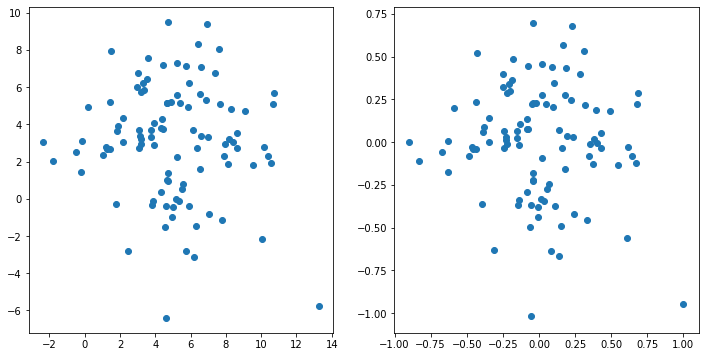

In [28]:
u1 = num.random.normal( 0, 1, (100,3))
u1[:,-1] = 1
m1 = num.random.uniform( -5, 5, (3,2))
x1 = num.dot( u1, m1)
x2 = (x1-x1.mean(0))/num.square(x1.std(0))

sp1 = mpl.subplot( 1, 2, 1)
sp2 = mpl.subplot( 1, 2, 2)
sp1.scatter( x1[:,0], x1[:,1])
sp2.scatter( x2[:,0], x2[:,1])
mpl.show()

Notar que las correlaciones entre las variables no cambian, pero después del preprocesado quedan centradas en el origen y en un rango aproximado entre -1 y 1, que es mucho más fácil de usar para una red neuronal.

Tener en cuenta que esto es válido tanto para variables de entrada como de salida, y en el caso de éstas últimas, si se espera que la red haga una predicción sobre valores reales, en muchos casos es conveniente que la respuesta de la red esté acotada y después aplicar una corrección a estos valores para adaptarlos a los del problema concreto.

Otro problema común con datos reales son los *outliers*, que suelen tener que ver más con errores introducidos en el proceso de medición o de anotación. Por ejemplo una variable que suele tomar valores alrededor de *30*, en una instancia aparece con un valor cercano a *300*, producido probablemente por un punto decimal mal anotado.

Estas instancias generalmente se las descartar, ya que no es posible saber la causa del error y cuál es el valor real correspondiente, pero no siempre es fácil detectarlas.


## Ruido y Azar

Una característica de los datos reales es que siempre existe un nivel de ruido en ellos. Y este ruido no debe ser considerado como un error proveniente de las mediciones, sino como una característica real de las variables que describen al problema. Es decir, no debemos tratar de cambiar los datos sino de elegir un modelo adecuado a ellos.

Por ejemplo, en las siguientes figuras, a la izquierda los puntos rojos son el conjunto de datos que describe el problema, la curva azul es una mejor aproximación a la solución que una curva que pase exactamente por todos los puntos; y a la derecha, un clasificador lineal que separe el espacio dejando la mayoría de los puntos rojos de un lado y los azules del otro es mejor que un modelo más complejo que incorpore a todos los puntos, incluyendo a los invertidos.

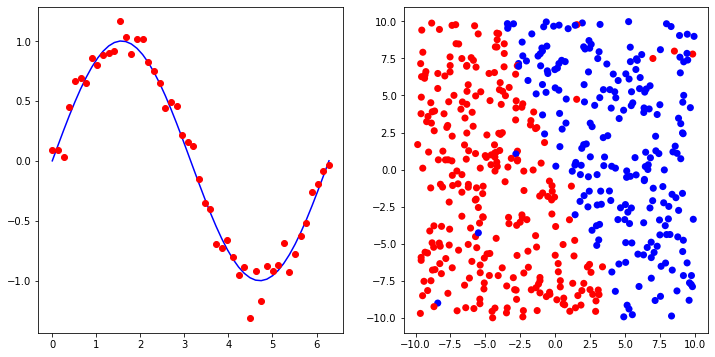

In [29]:
P1 = 50
x1 = num.linspace( 0, 2*num.pi, P1)
y1 = num.sin( x1)
r1 = num.random.normal( 0, 0.1, P1)

P2 = 500
x2 = num.random.uniform( -10, 10, (P2,3))
x2[:,-1] = 1
m2 = num.random.normal( 0, 1, (3,1))
y2 = num.sign( num.dot( x2, m2))
y2[num.random.choice( P2, 10)] *= -1


sp1 = mpl.subplot( 1, 2, 1)
sp2 = mpl.subplot( 1, 2, 2)
sp1.plot( x1, y1, 'b-', x1, y1+r1, 'ro')
sp2.scatter( x2[:,0], x2[:,1], c=y2.flatten(), s=50, cmap=cm.bwr, edgecolors='none')
mpl.show()


Se debe pensar en los datos disponibles como ejemplos de un problema, y lo que en verdad se busca es que el modelo dé una buena respuesta con ejemplos nuevos, casos que no fueron parte del aprendizaje.
Con problemas como los de la figura anterior, si se elije una arquitectura de red neuronal que durante el entrenamiento llegue a un error muy cercano a cero, probablemente esta funcionará incorrectamente con otros datos.
El modelo va a *memorizar* los ejemplos, y no va a poder *generalizar* correctamente para otros casos. 
A esto se lo suele llamar *overfitting* y por lo general es el resultado de elegir un modelo innecesariamente complejo. Por ejemplo una arquitectura de red con demasiadas capas ocultas o demasiadas unidades por capa, es decir, con demasiados parámetros entrenables.
Esto no significa que no haya problemas que requieran arquitecturas complejas, de hecho una arquitectura con menos parámetros entrenables de los necesarios conduce al problema opuesto, *underfitting*.

Por esto vamos a considerar que el proceso de aprendizaje no consiste solamente en entrenar una red neuronal, sino que también incluye elegir la mejor arquitectura de red posible.
Y para el primer paso de este proceso vamos a empezar por separar una parte del conjunto de datos en lo que llamaremos *datos de testeo*. 
Este subconjunto representa una porción relativamente chica (entre el 1% y el 10%) de los datos disponibles, y no participa para nada en el proceso de aprendizaje. Es decir, no se van a utilizar ni en el entrenamiento, ni en la elección del modelo.
La idea es que, una vez que tenga un modelo entrenado con una arquitectura que crea adecuada, pueda usar estos datos para probar que tan efectivo es realmente.

El resto de los datos disponibles se van a utilizar para elegir un modelo adecuado y para entrenar el modelo final. 
Como el principal interés es saber que tan bien se va a comportar el modelo con casos nuevos, el conjunto de datos será separado en *datos de entrenamiento* y *datos de validación* (por ejemplo, 75% para entrenar y 25% para validar).
Los datos de validación no serán usados durante el entrenamiento y servirán para poder evaluar el modelo simulando datos nuevos.
Esta forma de validación es conocida como *hold-out* y es suficientemente sencilla para nuestras necesidades. 
Sin embargo existen otras técnicas como *cross-validation* que son ampliamente utilizadas debido a su eficacia, pero sobre las que no vamos a profundizar aquí, ya que en verdad el *aprendizaje de datos* es una disciplina en sí misma.

El ciclo de aprendizaje consistirá entonces en:
- Elegir una arquitectura para el modelo.
- Usar los *datos de entrenamiento* para entrenar el modelo elegido.
- Usar los *datos de validación* para evaluar el modelo entrenado.
- Si se obtienen malos resultados se debe repetir el proceso con una nueva la arquitectura.
- Si se obtienen buenos resultados se debe repitir el experimento con un nuevo modelo de igual arquitectura.

Una vez que se tiene suficiente confianza, después de haber entrenado y validado varios modelos con la misma arquitectura exitosamente, se puede proceder a entrenar el modelo final, pero esta vez incluyendo también los *datos de validación* en el entrenamiento. Finalmente se lo puede hacer la evaluación definitiva con los *datos de testeo*.

Todos las divisiones de datos se deben realizar al azar. Para esto podemos usar la función *permutation* para generar un conjunto de índices que pueden ser utilizados en los arrays de *numpy* para seleccionar elementos.

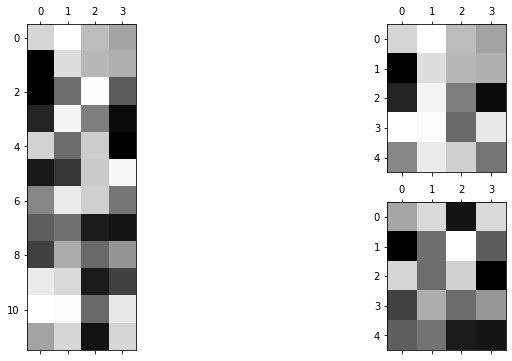

In [47]:
P = 12
dataset = num.random.uniform( -1, 1, (P,4))
indexes = num.random.permutation(P)

tst = indexes[-2:]
trn = indexes[0:5]
val = indexes[5:10]

sp1 = mpl.subplot( 1, 2, 1)
sp2 = mpl.subplot( 2, 2, 2)
sp3 = mpl.subplot( 2, 2, 4)
sp1.matshow( dataset, cmap=cm.gray)
sp2.matshow( dataset[trn], cmap=cm.gray)
sp3.matshow( dataset[val], cmap=cm.gray)
mpl.show()


En muchos casos los datos de problemas reales pueden ser muy díficiles o costosos de conseguir, lo cual no solo hace que se deba tener especial cuidado con todas estas particiones, sino que también introduce otros tipos de problemas.

Por ejemplo, como norma se puede considerar que si el modelo a utilizar tiene 10 veces más parámetros entrenables que instancias de datos disponibles, entonces no es posible realizar un aprendizaje efectivo.
Esto es peor con la llamada *curse-of-dimensinality*, esto es, si la dimensionalidad de los datos, es decir la cantidad de variables por patrón, es considerablemente grande en relación a la cantidad de instancias.


## Entrenamiento estocástico

Durante el entrenamiento los datos suelen ser particionados nuevamente en *mini-lotes*. Cada uno de estos subconjuntos son utilizados para calcular las correcciones a los pesos. Para cada época se construyen nuevas particiones al azar, ya que este elemento estocástico suele mejorar las notablemente las posibilidades de converger a una buena solución.

En particular, elegir los datos al azar individualmente, es decir en *mini-lotes* de tamaño 1, es los que se conoce como **Stochastic Gradient Descent** (SGD), y es uno de los métodos más utilizados en el entrenamiento de redes neuronales.


In [45]:
P = 10    # Tamaño del conjunto de entrenamiento.
B = 2     # Tamaño de los mini-lotes.

x = num.random.uniform( 0, 1, (P,3))
z = num.random.uniform( 0, 1, (P,2))

stochastic = num.random.permutation(P)
for batch in range(0,P,B):
    h = stochastic[ batch : batch+B ]
    Xh = x[h]
    Zh = z[h]
    print( "X:", Xh)
    print( "Z:", Zh)
    print("----")


X: [[0.65109864 0.96788583 0.00253   ]
 [0.47679698 0.17656337 0.51849411]]
Z: [[0.67727519 0.28094174]
 [0.60984368 0.4055295 ]]
----
X: [[0.87913035 0.08417031 0.81600525]
 [0.6949628  0.5455466  0.81269289]]
Z: [[0.41943203 0.56287535]
 [0.98218912 0.60131677]]
----
X: [[0.22803294 0.19647521 0.01830858]
 [0.18547903 0.29739089 0.90666129]]
Z: [[0.15421132 0.41936228]
 [0.88887339 0.18056848]]
----
X: [[0.85390335 0.43764452 0.17833196]
 [0.44341665 0.08898568 0.10153982]]
Z: [[0.52177181 0.45038751]
 [0.97414929 0.95211179]]
----
X: [[0.49850395 0.40182984 0.14698036]
 [0.37308238 0.71605912 0.80353733]]
Z: [[0.23311867 0.62014401]
 [0.56756906 0.78554995]]
----
